In [1]:
# imports for PyTorch and other necessary modules
import torch
from torch import nn, optim
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

Use the following generator architecture (which is essentially the reverse of a standard discriminative architecture). You can use the same kernel size. Construct:
• a dense layer that takes a unit Gaussian noise vector of length 100 and mapsittoavectorofsize7∗7∗256. Nobiasterms.
• severaltranspose2Dconvolutions(256×7×7 → 128×7×7 → 64 × 14 × 14 → 1 × 28 × 28). No bias terms.
• each convolutional layer (except the last one) is equipped with Batch Normalization (batch norm), followed by Leaky ReLU with slope 0.3. The last (output) layer is equipped with tanh activation (no batch norm).

In [2]:
# Generator class for producing image from noise
# ConvTranspose2d for upscaling, BatchNorm for stabilization, and LeakyReLU for non-linearity
class Generator(nn.Module):
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()
        self.features = features
        self.linear = nn.Linear(noise_channels, self.features * 4 * 7 * 7, bias=False)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.features * 4, self.features * 2, 5, 1, 2, bias=False),
            nn.BatchNorm2d(self.features * 2),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.features * 2, self.features, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(self.features),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(self.features, image_channels, 5, 2, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, self.features * 4, 7, 7)
        return self.model(x)


Use the following discriminator architecture (kernel size = 5 × 5 with stride = 2 in both directions):
• 2Dconvolutions(1×28×28→64×14×14→128×7×7)
• each convolutional layer is equipped with a Leaky ReLU with slope
0.3, followed by Dropout with parameter 0.3.
• a dense layer that takes the flattened output of the last convolution and
maps it to a scalar.

In [3]:
# Discriminator class to classify real vs fake images
# Conv2d for feature extraction, Dropout for regularization, and Sigmoid for output activation
class Discriminator(nn.Module):
    def __init__(self, image_channels, features=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, features, 5, 2, 2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Conv2d(features, features * 2, 5, 2, 2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(features * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# Setting up the device, learning rate, batch size, and number of epochs
# Device setup to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 50

Use the FashionMNIST training dataset (which we used in previous assign- ments) to train the DCGAN. Images are grayscale and size 28 × 28.

In [5]:
# Prepare transformations, load FashionMNIST dataset
# DataLoader does batch-wise iteration over dataset
transforms = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FashionMNIST(root="./data", train=True, transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Use the binary cross-entropy loss for training both the generator and the discriminator. Use the Adam optimizer with learning rate 10^−4.

In [6]:
# Set up generator and discriminator models, optimizers, and loss function
gen_model = Generator(100, 1, 64).to(device)
disc_model = Discriminator(1, 64).to(device)
gen_optimizer = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [7]:
print("Discriminator parameters:", sum(p.numel() for p in disc_model.parameters()))
print("Generator parameters:", sum(p.numel() for p in gen_model.parameters()))

Discriminator parameters: 212865
Generator parameters: 2280384


Train it for 50 epochs. You can use minibatch sizes of 16, 32, or 64. Training may take several minutes (or even up to an hour), so be patient! Display intermediate images generated after T = 10, T = 30, and T = 50 epochs.

Epoch [10/50] :: Batch [938/938]: 100%|██████████| 938/938 [00:22<00:00, 40.81it/s, Dloss=1.32, Gloss=1.04]


Epoch [10/50], d_loss: 1.3183, g_loss: 1.0445


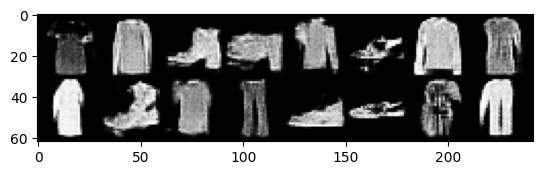

Epoch [30/50] :: Batch [938/938]: 100%|██████████| 938/938 [00:22<00:00, 40.95it/s, Dloss=1.33, Gloss=0.984]


Epoch [30/50], d_loss: 1.3350, g_loss: 0.9837


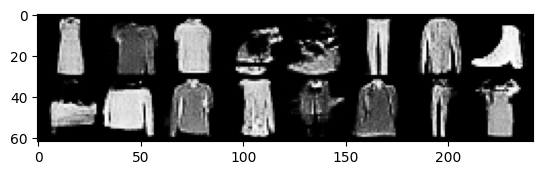

Epoch [50/50] :: Batch [938/938]: 100%|██████████| 938/938 [00:24<00:00, 38.98it/s, Dloss=1.27, Gloss=0.882]


Epoch [50/50], d_loss: 1.2707, g_loss: 0.8822


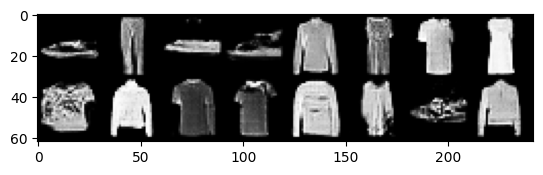

In [8]:
# Training loop for the GAN
# Displays loss statistics and generated images at specified epochs - 10th, 30th, 50th

disc_losses = []
gen_losses = []

for epoch in range(EPOCHS):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    for i, (images, _) in loop:
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        real_outputs = disc_model(images)
        d_loss_real = criterion(real_outputs, real_labels)

        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = gen_model(noise)
        fake_outputs = disc_model(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        disc_optimizer.zero_grad()
        d_loss.backward()
        disc_optimizer.step()

        outputs = disc_model(fake_images)
        g_loss = criterion(outputs, real_labels)
        gen_optimizer.zero_grad()
        g_loss.backward()
        gen_optimizer.step()

        disc_losses.append(d_loss.item())
        gen_losses.append(g_loss.item())

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}] :: Batch [{i + 1}/{len(dataloader)}]")
        loop.set_postfix(Dloss=d_loss.item(), Gloss=g_loss.item())

    if (epoch + 1) in [10, 30, 50]:
        print(f'Epoch [{epoch + 1}/{EPOCHS}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
        with torch.no_grad():
            fixed_noise = torch.randn(16, 100, device=device)
            fake_images = gen_model(fixed_noise)
            img_grid = torchvision.utils.make_grid(fake_images, normalize=True)
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

# Save models
torch.save(gen_model.state_dict(), 'generator.pth')
torch.save(disc_model.state_dict(), 'discriminator.pth')

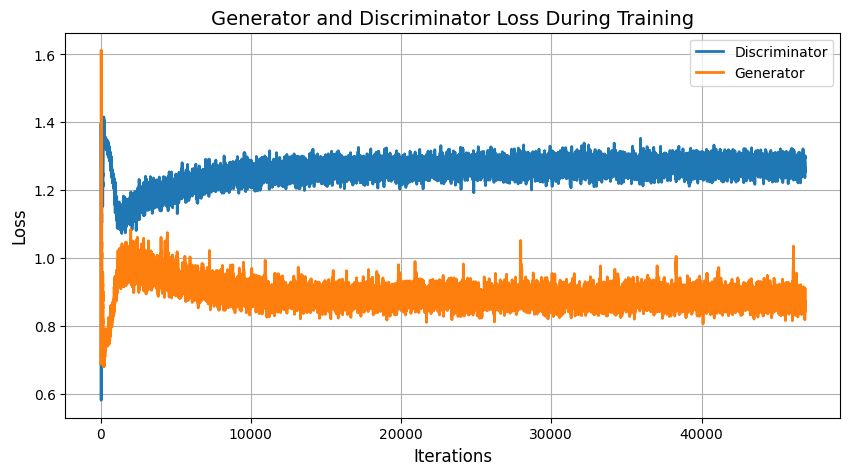

In [9]:
# Function to smooth losses for smoother plot
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth losses for visualization
smoothed_disc_losses = smooth_curve(disc_losses)
smoothed_gen_losses = smooth_curve(gen_losses)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training", fontsize=14)
plt.plot(smoothed_disc_losses, label="Discriminator", linewidth=2)
plt.plot(smoothed_gen_losses, label="Generator", linewidth=2)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## **Observations**

I observed notable advances in the generator's performance during GAN training on the FashionMNIST dataset, as it gradually started to produce more realistic images. The discriminator performed better in the beginning, but as learning rates and optimizer parameters were changed, the two models eventually came into balance, minimizing problems like mode collapse. The ultimate image quality was higher, demonstrating the GAN's ability to produce realistic images.

**Explanation**(!Comments in the code also explains the code)

1. **Generator and Discriminator Architecture**

Generator: Takes a random noise vector and uses several layers of transposed convolutions (also known as deconvolutions) to upscale this input into a 28x28 image. Batch normalization and LeakyReLU activation (except in the output layer, which uses a tanh activation) are used to stabilize training and introduce non-linearity.

Discriminator: Takes an input image and uses convolutions to downscale it to a single scalar output that predicts whether the input image is real or fake. It uses LeakyReLU for activation and dropout for regularization to prevent overfitting.

2.  **Setup and Data Loading**

Device Setup: Configures the PyTorch device to use GPU if available for faster computation.

Data Loading: The FashionMNIST dataset, which contains 28x28 grayscale images of fashion items, is loaded. A series of transformations (resizing, converting to tensor, and normalizing) are applied to prepare the data for the network.

3.  **Training Process**

Loss Function: Binary cross-entropy loss is used for both the generator and discriminator.

Optimizers: The Adam optimizer is used for both models with a specific learning rate and beta parameters to control the learning dynamics.

Training Loop: In each epoch, the discriminator is trained first by optimizing its ability to distinguish real images from fake ones. The generator is then trained to fool the discriminator by optimizing towards getting the discriminator to predict 'real' for generated images. Losses are recorded and periodically, generated images are displayed to monitor the training progress.

4.  **Output Visualization**

Plotting Losses: The losses for both generator and discriminator are plotted to observe the training process. This can help identify issues like mode collapse or whether the generator is overpowering the discriminator or vice versa.

Generated Images: At specified epochs, images generated by the generator are displayed to visually assess the improvement and realism of generated images over training.
